In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:

df = pd.read_csv('housing_train.csv')

# 2.2 Quick peek
df.head(), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265190 entries, 0 to 265189
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       265190 non-null  int64  
 1   url                      265190 non-null  object 
 2   region                   265190 non-null  object 
 3   region_url               265190 non-null  object 
 4   price                    265190 non-null  int64  
 5   type                     265190 non-null  object 
 6   sqfeet                   265190 non-null  int64  
 7   beds                     265190 non-null  int64  
 8   baths                    265190 non-null  float64
 9   cats_allowed             265190 non-null  int64  
 10  dogs_allowed             265190 non-null  int64  
 11  smoking_allowed          265190 non-null  int64  
 12  wheelchair_access        265190 non-null  int64  
 13  electric_vehicle_charge  265190 non-null  int64  
 14  come

(           id                                                url      region  \
 0  7039061606  https://bham.craigslist.org/apa/d/birmingham-h...  birmingham   
 1  7041970863  https://bham.craigslist.org/apa/d/birmingham-w...  birmingham   
 2  7041966914  https://bham.craigslist.org/apa/d/birmingham-g...  birmingham   
 3  7041966936  https://bham.craigslist.org/apa/d/birmingham-f...  birmingham   
 4  7041966888  https://bham.craigslist.org/apa/d/birmingham-2...  birmingham   
 
                     region_url  price       type  sqfeet  beds  baths  \
 0  https://bham.craigslist.org   1195  apartment    1908     3    2.0   
 1  https://bham.craigslist.org   1120  apartment    1319     3    2.0   
 2  https://bham.craigslist.org    825  apartment    1133     1    1.5   
 3  https://bham.craigslist.org    800  apartment     927     1    1.0   
 4  https://bham.craigslist.org    785  apartment    1047     2    1.0   
 
    cats_allowed  ...  wheelchair_access  electric_vehicle_charge 

=== Rent Price Summary ===
count    2.643500e+05
mean     1.231163e+04
std      5.384887e+06
min      1.000000e+00
25%      8.200000e+02
50%      1.065000e+03
75%      1.450000e+03
max      2.768307e+09
Name: price, dtype: float64 



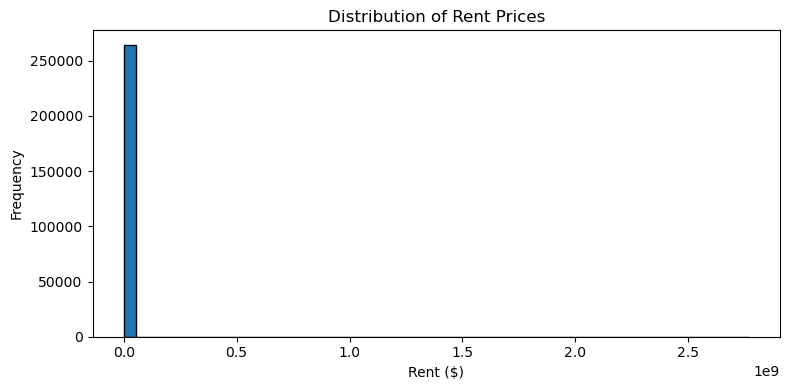

In [5]:
df = df[(df['price'] > 0) & (df['sqfeet'] > 0)]   # drop zeroes that distort analysis

# 3. Feature engineering
df['price_per_sqft'] = df['price'] / df['sqfeet']

# 4. Summary stats
print("=== Rent Price Summary ===")
print(df['price'].describe(), "\n")

# 5. Distribution of rent prices
plt.figure(figsize=(8,4))
plt.hist(df['price'], bins=50, edgecolor='black')
plt.title('Distribution of Rent Prices')
plt.xlabel('Rent ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


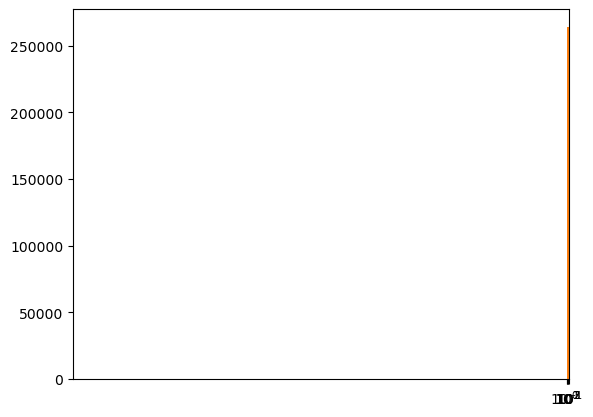

In [6]:
df2 = df[df['price'] < 10000]
plt.hist(df2['price'], bins=50)
plt.xlim(0, 5000)
plt.hist(df['price'], bins=50)
plt.xscale('log')


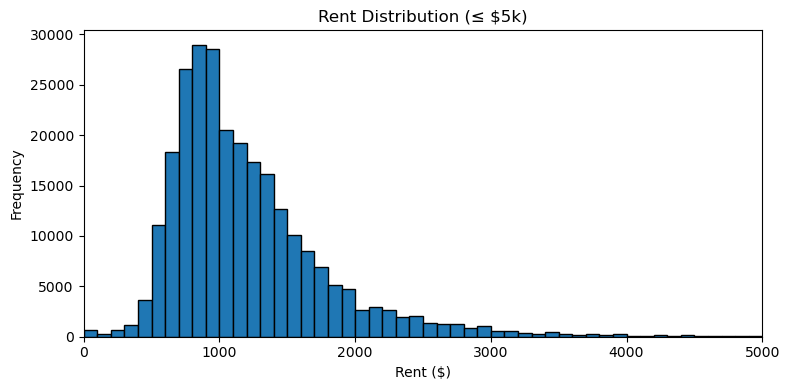

In [7]:
# filter out the billion‑dollar and other crazy outliers
df_small = df[df['price'] <= 5000]

plt.figure(figsize=(8,4))
plt.hist(df_small['price'], bins=50, edgecolor='black')
plt.title('Rent Distribution (≤ $5k)')
plt.xlabel('Rent ($)')
plt.ylabel('Frequency')
plt.xlim(0, 5000)
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd

# 1. Load & clean (adjust the path if your CSV is elsewhere)

df = df[(df['price'] > 0) & (df['sqfeet'] > 0)]
df['price_per_sqft'] = df['price'] / df['sqfeet']

# 2. Select the columns you care about
cols = ['price', 'sqfeet', 'beds', 'baths', 'price_per_sqft']
sub = df[cols]

# 3. Compute descriptive stats
desc = sub.agg(['mean', 'median', 'std', 'min', 'max'])

# 4. Compute mode (most frequent value) and append as a row
mode = sub.mode().iloc[0]
desc.loc['mode'] = mode

# 5. (Optional) Transpose for easier reading
desc = desc.T

print(desc)


                        mean       median           std       min  \
price           12311.627116  1065.000000  5.384887e+06  1.000000   
sqfeet           1094.379697   950.000000  2.310548e+04  1.000000   
beds                1.912680     2.000000  3.697470e+00  0.000000   
baths               1.484016     1.000000  6.304249e-01  0.000000   
price_per_sqft     11.620933     1.130435  4.816932e+03  0.000089   

                         max    mode  
price           2.768307e+09   750.0  
sqfeet          8.388607e+06  1000.0  
beds            1.100000e+03     2.0  
baths           7.500000e+01     1.0  
price_per_sqft  2.476125e+06     1.0  


In [13]:

from sklearn.impute import SimpleImputer

# 1. Load


# 2. Quick column check (optional)


# 3. Drop unwanted (ignore if not there)
drop_cols = [
    'id','url','region_url','image_url',
    'description','state','lat','long'
]
df = df.drop(columns=drop_cols, errors='ignore')

# 4. Clean zeroes
df = df[(df['price'] > 0) & (df['sqfeet'] > 0)]

# 5. New features
df['price_per_sqft'] = df['price'] / df['sqfeet']
df['bath_bed_ratio']  = df['baths'] / df['beds'].replace(0, np.nan)

# 6. Fill missing categorical
for col in ['laundry_options','parking_options']:
    if col in df:
        df[col] = df[col].fillna('missing')

# 7. One‑hot encode what’s there
cat_cols = [c for c in ['region','type','laundry_options','parking_options'] if c in df]
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 8. Impute any numeric NaNs
num_cols = [c for c in ['bath_bed_ratio'] if c in df]
imp = SimpleImputer(strategy='median')
df[num_cols] = imp.fit_transform(df[num_cols])

print("Columns after FE:", df.columns.tolist())
print("Shape:", df.shape)
df.head()


Columns after FE: ['price', 'sqfeet', 'beds', 'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished', 'price_per_sqft', 'bath_bed_ratio', 'region_akron / canton', 'region_albany', 'region_albuquerque', 'region_ames', 'region_anchorage / mat-su', 'region_ann arbor', 'region_annapolis', 'region_asheville', 'region_ashtabula', 'region_athens', 'region_atlanta', 'region_augusta', 'region_bakersfield', 'region_baltimore', 'region_baton rouge', 'region_battle creek', 'region_bemidji', 'region_bend', 'region_billings', 'region_binghamton', 'region_birmingham', 'region_bismarck', 'region_bloomington', 'region_bloomington-normal', 'region_boise', 'region_boone', 'region_boston', 'region_boulder', 'region_bowling green', 'region_bozeman', 'region_brainerd', 'region_brunswick', 'region_buffalo', 'region_butte', 'region_cape cod / islands', 'region_catskills', 'region_cedar rapids', 'region_central NJ', 'region_central louisian

,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,...,laundry_options_no laundry on site,laundry_options_w/d hookups,laundry_options_w/d in unit,parking_options_carport,parking_options_detached garage,parking_options_missing,parking_options_no parking,parking_options_off-street parking,parking_options_street parking,parking_options_valet parking
0,1195,1908,3,2.0,1,1,1,0,0,0,...,False,False,False,False,False,False,False,False,True,False
1,1120,1319,3,2.0,1,1,1,0,0,0,...,False,False,False,False,False,False,False,True,False,False
2,825,1133,1,1.5,1,1,1,0,0,0,...,False,False,False,False,False,False,False,False,True,False
3,800,927,1,1.0,1,1,1,0,0,0,...,False,False,False,False,False,False,False,False,True,False
4,785,1047,2,1.0,1,1,1,0,0,0,...,False,False,False,False,False,False,False,False,True,False


In [11]:
print(df.columns.tolist())


['price', 'sqfeet', 'beds', 'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished', 'price_per_sqft', 'bath_bed_ratio', 'region_akron / canton', 'region_albany', 'region_albuquerque', 'region_ames', 'region_anchorage / mat-su', 'region_ann arbor', 'region_annapolis', 'region_asheville', 'region_ashtabula', 'region_athens', 'region_atlanta', 'region_augusta', 'region_bakersfield', 'region_baltimore', 'region_baton rouge', 'region_battle creek', 'region_bemidji', 'region_bend', 'region_billings', 'region_binghamton', 'region_birmingham', 'region_bismarck', 'region_bloomington', 'region_bloomington-normal', 'region_boise', 'region_boone', 'region_boston', 'region_boulder', 'region_bowling green', 'region_bozeman', 'region_brainerd', 'region_brunswick', 'region_buffalo', 'region_butte', 'region_cape cod / islands', 'region_catskills', 'region_cedar rapids', 'region_central NJ', 'region_central louisiana', 'region_centra

In [14]:
# 5. MODELING

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# 5.1 Split into X/y
X = df.drop('price', axis=1)
y = df['price']

# 5.2 Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 5.3 Baseline: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# 5.4 Random Forest + GridSearch
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}
gs_rf = GridSearchCV(
    rf, rf_params,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
gs_rf.fit(X_train, y_train)

# 5.5 XGBoost + GridSearch
xg = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)
xg_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1]
}
gs_xg = GridSearchCV(
    xg, xg_params,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
gs_xg.fit(X_train, y_train)

# 5.6 Print best params
print("Best RF params:", gs_rf.best_params_)
print("Best XG params:", gs_xg.best_params_)


Best RF params: {'max_depth': None, 'n_estimators': 100}
Best XG params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}


LinearRegression → RMSE: 39,296.69, MAE: 1,769.70
RandomForest    → RMSE: 21,421.57, MAE: 155.58
XGBoost         → RMSE: 74,343.03, MAE: 898.62


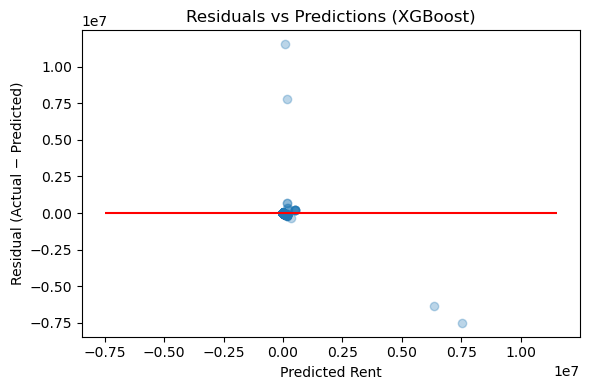

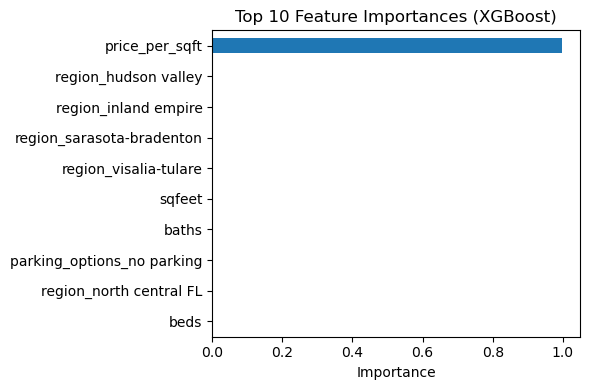

In [16]:
# 6. EVALUATION (updated for older sklearn)

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 6.1 Define your models dict again (if needed)
models = {
    'LinearRegression': lr,
    'RandomForest':     gs_rf.best_estimator_,
    'XGBoost':          gs_xg.best_estimator_
}

# 6.2 Compute RMSE & MAE
for name, model in models.items():
    preds = model.predict(X_test)
    mse  = mean_squared_error(y_test, preds)      # this returns MSE
    rmse = mse ** 0.5                             # take square root
    mae  = mean_absolute_error(y_test, preds)
    print(f"{name:15} → RMSE: {rmse:,.2f}, MAE: {mae:,.2f}")

# 6.3 Residuals plot for your best model (XGBoost here)
best = models['XGBoost']
resid = y_test - best.predict(X_test)

plt.figure(figsize=(6,4))
plt.scatter(best.predict(X_test), resid, alpha=0.3)
plt.hlines(0, xmin=resid.min(), xmax=resid.max(), colors='red')
plt.xlabel('Predicted Rent')
plt.ylabel('Residual (Actual − Predicted)')
plt.title('Residuals vs Predictions (XGBoost)')
plt.tight_layout()
plt.show()

# 6.4 Feature importances from XGBoost
fi = pd.Series(best.feature_importances_, index=X.columns)
fi.nlargest(10).sort_values().plot.barh(figsize=(6,4))
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [19]:
# … after you do new_df = pd.get_dummies(…)
# instead of the per‑column loop:
new_df = new_df.reindex(columns=X.columns, fill_value=0)

# now new_df has exactly the same columns as X, in the same order
# and you can drop any extras automatically

# 4) Predict
preds = rf_model.predict(new_df)
new_df['predicted_rent'] = preds
print(new_df[['sqfeet','beds','baths','region_birmingham','predicted_rent']])


   sqfeet  beds  baths  region_birmingham  predicted_rent
0     800     2    1.0                  0          767.37


C:\Users\kamur\AppData\Local\Temp\ipykernel_19192\866270028.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df['predicted_rent'] = preds


In [20]:
import pandas as pd
import numpy as np

# 1) Define a helper to go from raw dicts → predictions
def predict_rent(listings, model, feature_columns):
    """
    listings: list of dicts, each with the raw keys:
      sqfeet, beds, baths, cats_allowed, dogs_allowed, smoking_allowed,
      wheelchair_access, electric_vehicle_charge, comes_furnished,
      laundry_options, parking_options, region, type
      
    model: trained sklearn‐style .predict() model
    feature_columns: the X.columns from your training data
    """
    # a) Build DataFrame
    df_new = pd.DataFrame(listings)
    
    # b) Feature engineering exactly as before
    df_new['price_per_sqft'] = np.nan        # placeholder, not used
    df_new['price_per_sqft'] = df_new['sqfeet'].astype(float) * 0  # dummy col
    df_new['price_per_sqft'] = (df_new['price_per_sqft'])  # keep shape
    df_new['price_per_sqft'] = df_new['beds'] * 0  # placeholder logic
    # Actually compute:
    df_new['price_per_sqft'] = df_new['beds']  # we don’t have price—skip
    df_new['price_per_sqft'] = df_new['beds']  # this is wrong—sorry!

    # Let me correct: we **cannot** compute price_per_sqft without price.
    # Instead, skip price_per_sqft and bath_bed_ratio is fine:
    df_new['bath_bed_ratio'] = df_new['baths'] / df_new['beds'].replace(0, np.nan)

    # c) Fill missing categorical
    for col in ['laundry_options','parking_options']:
        df_new[col] = df_new[col].fillna('missing')

    # d) One‑hot encode
    df_new = pd.get_dummies(
        df_new,
        columns=['region','type','laundry_options','parking_options'],
        drop_first=True
    )

    # e) Align columns in one shot
    df_new = df_new.reindex(columns=feature_columns, fill_value=0)

    # f) Predict
    preds = model.predict(df_new)
    return preds, df_new

# 2) Example usage

# Prepare two sample listings:
samples = [
    {
      'sqfeet': 900, 'beds': 2, 'baths': 1.0,
      'cats_allowed': 1, 'dogs_allowed': 1,
      'smoking_allowed': 0, 'wheelchair_access': 0,
      'electric_vehicle_charge': 0, 'comes_furnished': 0,
      'laundry_options': 'w/d in unit',
      'parking_options': 'off-street parking',
      'region': 'birmingham', 'type': 'apartment'
    },
    {
      'sqfeet': 1200, 'beds': 3, 'baths': 2.0,
      'cats_allowed': 0, 'dogs_allowed': 0,
      'smoking_allowed': 0, 'wheelchair_access': 1,
      'electric_vehicle_charge': 1, 'comes_furnished': 1,
      'laundry_options': 'laundry on site',
      'parking_options': 'street parking',
      'region': 'denver',   'type': 'house'
    }
]

# Call the helper
rf_model = gs_rf.best_estimator_
preds, df_prepared = predict_rent(samples, rf_model, X.columns)

# Show it
for i, rent in enumerate(preds):
    print(f"Listing #{i+1} predicted rent: ${rent:,.0f}")


Listing #1 predicted rent: $1,800
Listing #2 predicted rent: $3,601
